In [25]:
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
import random
from PIL import Image
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as functional
from torchvision import transforms

In [26]:
csv_path = "C:/Users/zhura/Desktop/paths.csv"
df = pd.read_csv(csv_path, delimiter=";", names=["Absolute path", "Relative path", "Tag"])
images = df["Absolute path"].to_list()
random.shuffle(images)
img_label=[]
for i in range(len(images)):
    img_label.append(os.path.basename(os.path.dirname(images[i])))
print(img_label[:10])

['brown bear', 'polar bear', 'polar bear', 'polar bear', 'polar bear', 'brown bear', 'polar bear', 'polar bear', 'polar bear', 'polar bear']


In [27]:
train_list = images[0:int(len(images) * 0.8)]
test_list = images[int(len(images) * 0.8) : int(len(images) * 0.9)]
valid_list = images[int(len(images) * 0.9) : int(len(images))]

print(len(train_list), len(test_list), len(valid_list))

1600 200 200


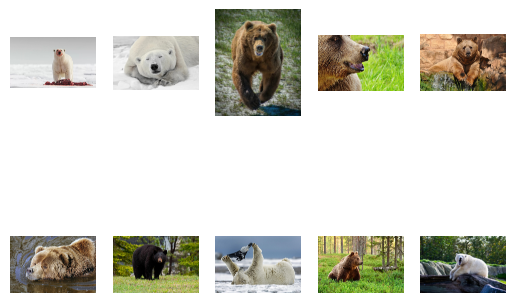

In [28]:
random_idx = np.random.randint(1,len(images),size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(images[idx])
    plt.imshow(img)
    i+=1
    plt.axis('off')
    
plt.show()

In [29]:
class dataset(torch.utils.data.Dataset):
    
    def __init__(self,dataset,transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        self.filelength = len(self.dataset)
        return self.filelength
    
    def __getitem__(self,index:int):
        img_label=[]
        for i in range(len(self.dataset)):
            img_label.append(os.path.basename(os.path.dirname(self.dataset[i])))
        img_path = self.dataset[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_label[index]
        if label == 'polar bear':
            label=0
        elif label == 'brown bear':
            label=1
        return img_transformed,label

In [30]:
fixed_transforms = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    )
train_data = dataset(train_list, transform=fixed_transforms)
test_data = dataset(test_list, transform=fixed_transforms)
val_data = dataset(valid_list, transform=fixed_transforms)
print(train_data.transform)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


In [31]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = output.view(output.size(0),-1)
        output = self.relu(self.fc1(output))
        output = self.fc2(output)
        return output

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
    
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [33]:
def draw_results(epochs, acc, loss, v_acc, v_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(range(epochs), acc, color="green", label="Train accuracy")
    ax2.plot(range(epochs), loss, color="green", label="Train loss")
    ax1.plot(range(epochs), v_acc, color="orange", label="Validation accuracy")
    ax2.plot(range(epochs), v_loss, color="orange", label="Validation loss")
    ax1.legend()
    ax2.legend()
    plt.show() 

In [34]:
def train_loop(epochs, batch_size, lear):
    optimizer = optim.Adam(params = model.parameters(),lr=lear)
    criterion = nn.CrossEntropyLoss()
    epochs = epochs
    accuracy_values = []
    loss_values = []
    val_accuracy_values=[]
    val_loss_values=[]
    val_loader = torch.utils.data.DataLoader(dataset = val_data, 
                                            batch_size=batch_size, 
                                            shuffle=False)
    train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                            batch_size=batch_size, 
                                            shuffle=True )
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)
            
        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        accuracy_values.append(epoch_accuracy.item())
        loss_values.append(epoch_loss.item())

        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0
            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)
                
                val_output = model(data)
                val_loss = criterion(val_output,label)
                
                
                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)
                
            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
            val_accuracy_values.append(epoch_val_accuracy.item())
            val_loss_values.append(epoch_val_loss.item()) 
    draw_results(epochs,accuracy_values, loss_values, val_accuracy_values, val_loss_values)

Epoch : 1, train accuracy : 0.8656250238418579, train loss : 0.34597909450531006
Epoch : 1, val_accuracy : 0.9399999380111694, val_loss : 0.1928321123123169
Epoch : 2, train accuracy : 0.9287498593330383, train loss : 0.18280306458473206
Epoch : 2, val_accuracy : 0.9399999380111694, val_loss : 0.16228336095809937
Epoch : 3, train accuracy : 0.9493748545646667, train loss : 0.14261697232723236
Epoch : 3, val_accuracy : 0.9649999737739563, val_loss : 0.10357801616191864
Epoch : 4, train accuracy : 0.9487500190734863, train loss : 0.13329759240150452
Epoch : 4, val_accuracy : 0.9699999690055847, val_loss : 0.10198643803596497
Epoch : 5, train accuracy : 0.9568749070167542, train loss : 0.12947632372379303
Epoch : 5, val_accuracy : 0.9699999690055847, val_loss : 0.08005667477846146
Epoch : 6, train accuracy : 0.9599999189376831, train loss : 0.1099388524889946
Epoch : 6, val_accuracy : 0.9699999690055847, val_loss : 0.06707671284675598
Epoch : 7, train accuracy : 0.9574999213218689, train 

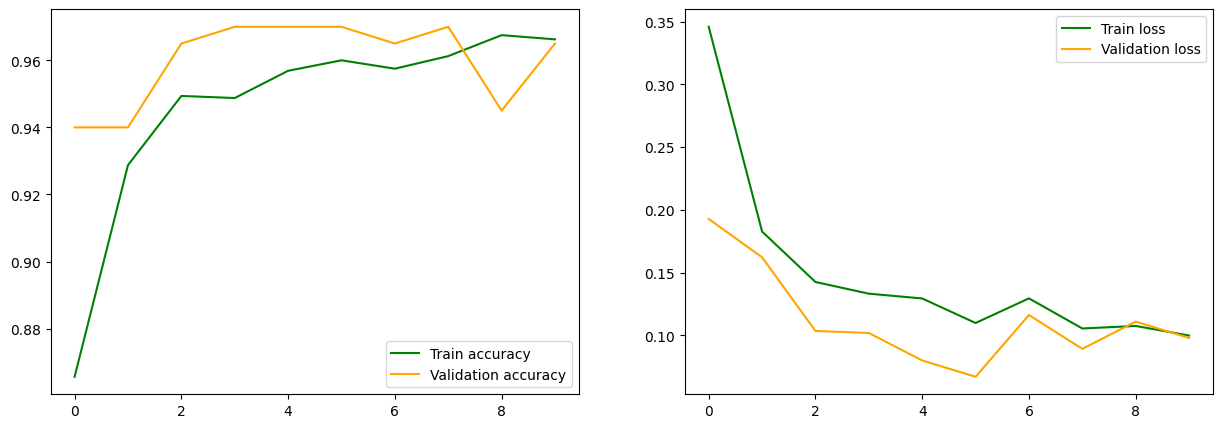

In [35]:
train_loop(10, 100, 0.001)  

Epoch : 1, train accuracy : 0.9731249213218689, train loss : 0.10172504931688309
Epoch : 1, val_accuracy : 0.9749999642372131, val_loss : 0.07849607616662979
Epoch : 2, train accuracy : 0.9699999094009399, train loss : 0.08913104981184006
Epoch : 2, val_accuracy : 0.9699999690055847, val_loss : 0.09038324654102325
Epoch : 3, train accuracy : 0.9787499904632568, train loss : 0.07674147933721542
Epoch : 3, val_accuracy : 0.9799999594688416, val_loss : 0.08684009313583374
Epoch : 4, train accuracy : 0.9706249833106995, train loss : 0.0849681869149208
Epoch : 4, val_accuracy : 0.9799999594688416, val_loss : 0.05176212638616562
Epoch : 5, train accuracy : 0.9749999046325684, train loss : 0.07798300683498383
Epoch : 5, val_accuracy : 0.9699999690055847, val_loss : 0.08981677889823914
Epoch : 6, train accuracy : 0.9706249833106995, train loss : 0.07410520315170288
Epoch : 6, val_accuracy : 0.9799999594688416, val_loss : 0.0470280647277832
Epoch : 7, train accuracy : 0.9775000214576721, train 

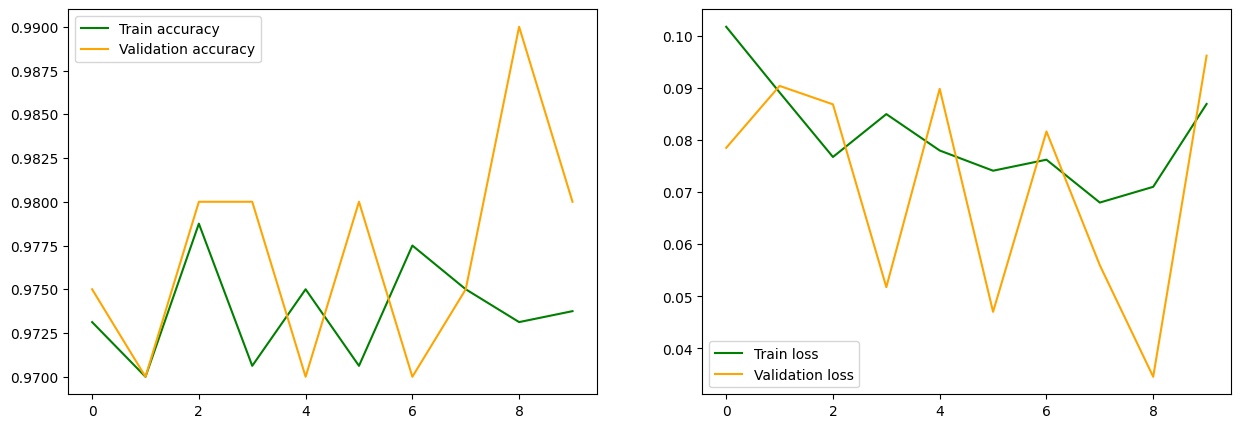

In [36]:
train_loop(10, 200, 0.001)

Epoch : 1, train accuracy : 0.9672223329544067, train loss : 0.10099729895591736
Epoch : 1, val_accuracy : 0.949999988079071, val_loss : 0.14235608279705048
Epoch : 2, train accuracy : 0.971666693687439, train loss : 0.08474987745285034
Epoch : 2, val_accuracy : 0.9749999642372131, val_loss : 0.06435135006904602
Epoch : 3, train accuracy : 0.9705555438995361, train loss : 0.07710373401641846
Epoch : 3, val_accuracy : 0.9799999594688416, val_loss : 0.07547600567340851
Epoch : 4, train accuracy : 0.9794445037841797, train loss : 0.06511539220809937
Epoch : 4, val_accuracy : 0.9799999594688416, val_loss : 0.08313656598329544
Epoch : 5, train accuracy : 0.9766666889190674, train loss : 0.07180625200271606
Epoch : 5, val_accuracy : 0.9749999642372131, val_loss : 0.058121562004089355
Epoch : 6, train accuracy : 0.9766666889190674, train loss : 0.06944172084331512
Epoch : 6, val_accuracy : 0.9699999690055847, val_loss : 0.05419867858290672
Epoch : 7, train accuracy : 0.9788888692855835, train

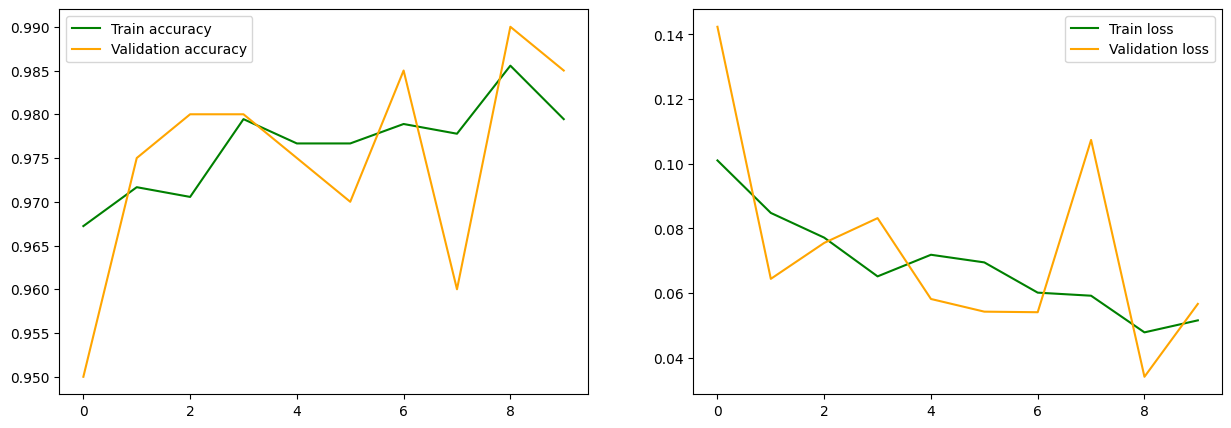

In [37]:
train_loop(10, 300, 0.001)

Epoch : 1, train accuracy : 0.9262499213218689, train loss : 0.2038145363330841
Epoch : 1, val_accuracy : 0.9599999785423279, val_loss : 0.12809672951698303
Epoch : 2, train accuracy : 0.9499999284744263, train loss : 0.140610933303833
Epoch : 2, val_accuracy : 0.949999988079071, val_loss : 0.12184622883796692
Epoch : 3, train accuracy : 0.9556249380111694, train loss : 0.12390568107366562
Epoch : 3, val_accuracy : 0.9649999737739563, val_loss : 0.09321540594100952
Epoch : 4, train accuracy : 0.95374995470047, train loss : 0.12064000964164734
Epoch : 4, val_accuracy : 0.9699999690055847, val_loss : 0.1005750298500061
Epoch : 5, train accuracy : 0.9556249976158142, train loss : 0.10291575640439987
Epoch : 5, val_accuracy : 0.9549999833106995, val_loss : 0.1593787670135498
Epoch : 6, train accuracy : 0.9556249380111694, train loss : 0.13003042340278625
Epoch : 6, val_accuracy : 0.9499999284744263, val_loss : 0.11024975776672363
Epoch : 7, train accuracy : 0.9549999237060547, train loss :

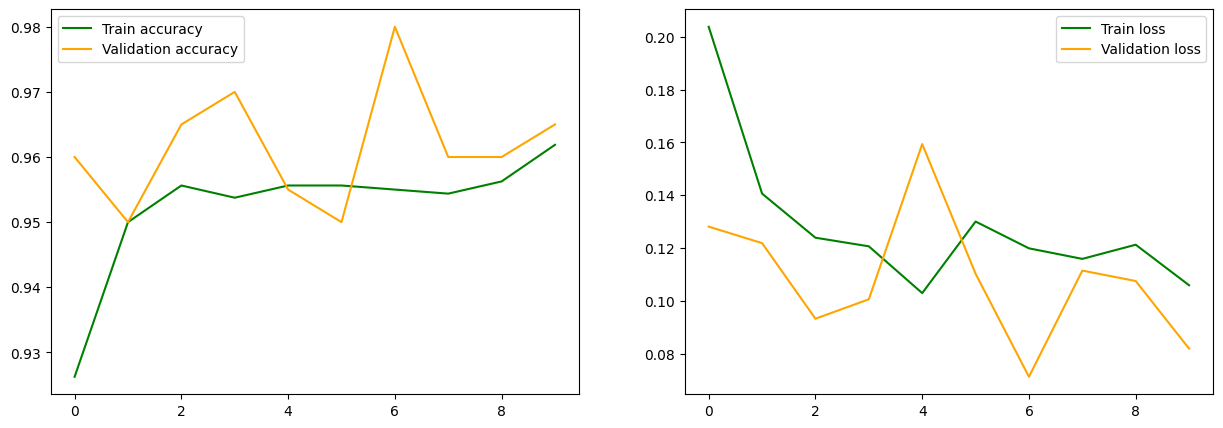

In [38]:
train_loop(10, 100, 0.005)

Epoch : 1, train accuracy : 0.9674999713897705, train loss : 0.08719701319932938
Epoch : 1, val_accuracy : 0.9649999737739563, val_loss : 0.09746302664279938
Epoch : 2, train accuracy : 0.9668749570846558, train loss : 0.09479755908250809
Epoch : 2, val_accuracy : 0.9749999642372131, val_loss : 0.08958114683628082
Epoch : 3, train accuracy : 0.9662500619888306, train loss : 0.0951429232954979
Epoch : 3, val_accuracy : 0.98499995470047, val_loss : 0.09235862642526627
Epoch : 4, train accuracy : 0.9662500023841858, train loss : 0.10385817289352417
Epoch : 4, val_accuracy : 0.9699999690055847, val_loss : 0.09756045043468475
Epoch : 5, train accuracy : 0.9737499356269836, train loss : 0.0787954181432724
Epoch : 5, val_accuracy : 0.949999988079071, val_loss : 0.13858923316001892
Epoch : 6, train accuracy : 0.9662500023841858, train loss : 0.09054361283779144
Epoch : 6, val_accuracy : 0.9749999642372131, val_loss : 0.06695582717657089
Epoch : 7, train accuracy : 0.9712499380111694, train los

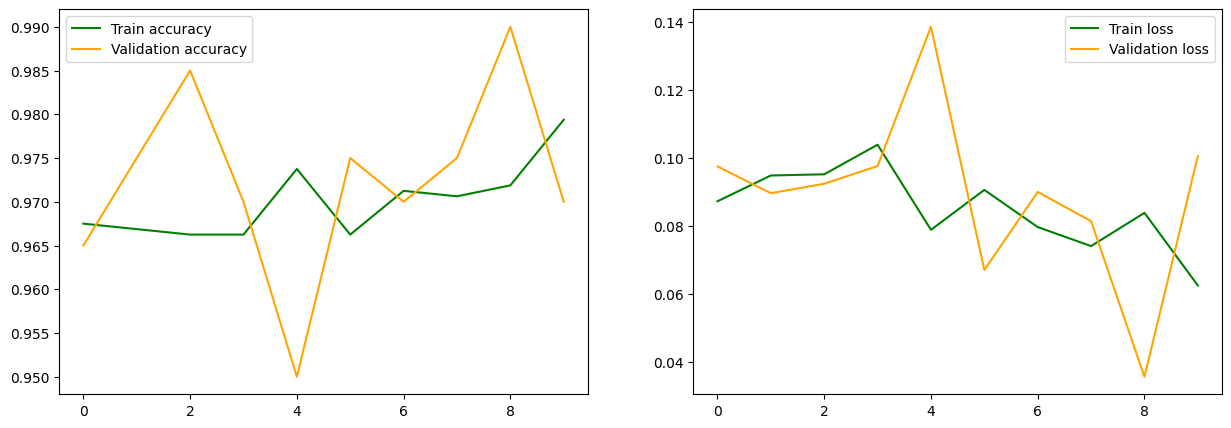

In [39]:
train_loop(10, 200, 0.005)   

Epoch : 1, train accuracy : 0.962777853012085, train loss : 0.09676867723464966
Epoch : 1, val_accuracy : 0.9749999642372131, val_loss : 0.060033537447452545
Epoch : 2, train accuracy : 0.9650000333786011, train loss : 0.0871167927980423
Epoch : 2, val_accuracy : 0.98499995470047, val_loss : 0.05636538937687874
Epoch : 3, train accuracy : 0.9700000882148743, train loss : 0.0909256786108017
Epoch : 3, val_accuracy : 0.9799999594688416, val_loss : 0.07107774913311005
Epoch : 4, train accuracy : 0.980555534362793, train loss : 0.0680018961429596
Epoch : 4, val_accuracy : 0.9749999642372131, val_loss : 0.09844296425580978
Epoch : 5, train accuracy : 0.9794445037841797, train loss : 0.06448791921138763
Epoch : 5, val_accuracy : 0.9649999737739563, val_loss : 0.13587112724781036
Epoch : 6, train accuracy : 0.9800000190734863, train loss : 0.055647384375333786
Epoch : 6, val_accuracy : 0.9749999642372131, val_loss : 0.058806486427783966
Epoch : 7, train accuracy : 0.9744445085525513, train lo

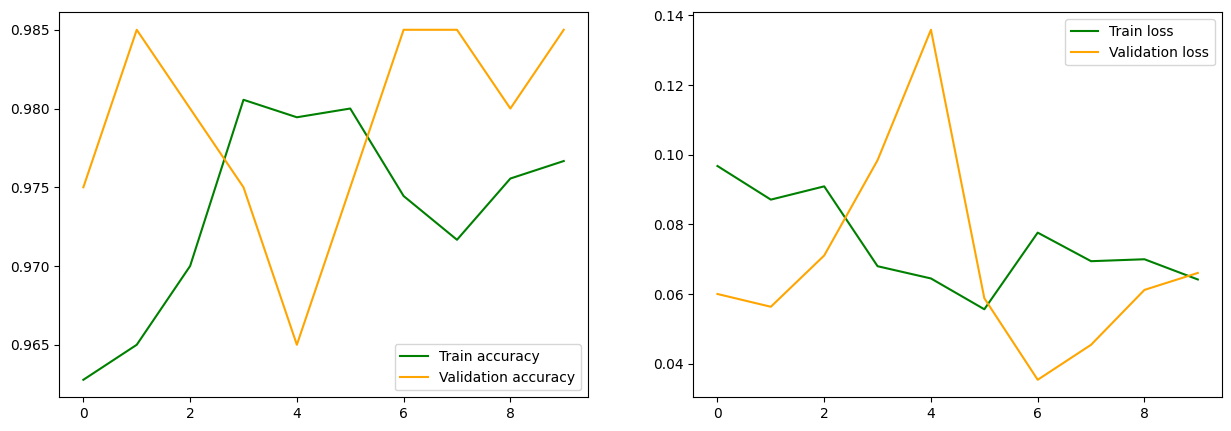

In [40]:
train_loop(10, 300, 0.005)

Epoch : 1, train accuracy : 0.9468749165534973, train loss : 0.1465667486190796
Epoch : 1, val_accuracy : 0.9800000190734863, val_loss : 0.06071971356868744
Epoch : 2, train accuracy : 0.964374840259552, train loss : 0.09315317124128342
Epoch : 2, val_accuracy : 0.9699999690055847, val_loss : 0.08286039531230927
Epoch : 3, train accuracy : 0.9749999046325684, train loss : 0.0865727961063385
Epoch : 3, val_accuracy : 0.9549999833106995, val_loss : 0.10135699808597565
Epoch : 4, train accuracy : 0.9718748927116394, train loss : 0.08326125890016556
Epoch : 4, val_accuracy : 0.9900000095367432, val_loss : 0.04418087750673294
Epoch : 5, train accuracy : 0.9674999117851257, train loss : 0.09146399050951004
Epoch : 5, val_accuracy : 0.9649999737739563, val_loss : 0.12584227323532104
Epoch : 6, train accuracy : 0.9712499380111694, train loss : 0.08252312242984772
Epoch : 6, val_accuracy : 0.9649999737739563, val_loss : 0.06760487705469131
Epoch : 7, train accuracy : 0.9743749499320984, train l

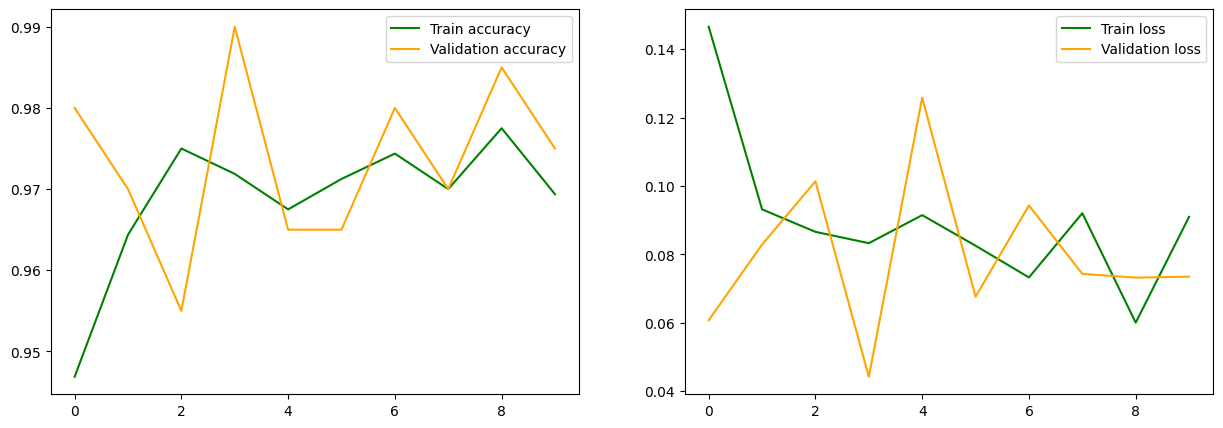

In [41]:

train_loop(10, 100, 0.007)

Epoch : 1, train accuracy : 0.9743749499320984, train loss : 0.07932154089212418
Epoch : 1, val_accuracy : 0.9749999642372131, val_loss : 0.08886847645044327
Epoch : 2, train accuracy : 0.9706249237060547, train loss : 0.08020170032978058
Epoch : 2, val_accuracy : 0.9549999833106995, val_loss : 0.11159492284059525
Epoch : 3, train accuracy : 0.971875011920929, train loss : 0.07806509733200073
Epoch : 3, val_accuracy : 0.9749999642372131, val_loss : 0.06896406412124634
Epoch : 4, train accuracy : 0.9831249713897705, train loss : 0.04703398793935776
Epoch : 4, val_accuracy : 0.9799999594688416, val_loss : 0.06959850341081619
Epoch : 5, train accuracy : 0.9731249809265137, train loss : 0.07387501001358032
Epoch : 5, val_accuracy : 0.9799999594688416, val_loss : 0.07761365175247192
Epoch : 6, train accuracy : 0.9806250333786011, train loss : 0.04736006259918213
Epoch : 6, val_accuracy : 0.98499995470047, val_loss : 0.04784100502729416
Epoch : 7, train accuracy : 0.9831249117851257, train l

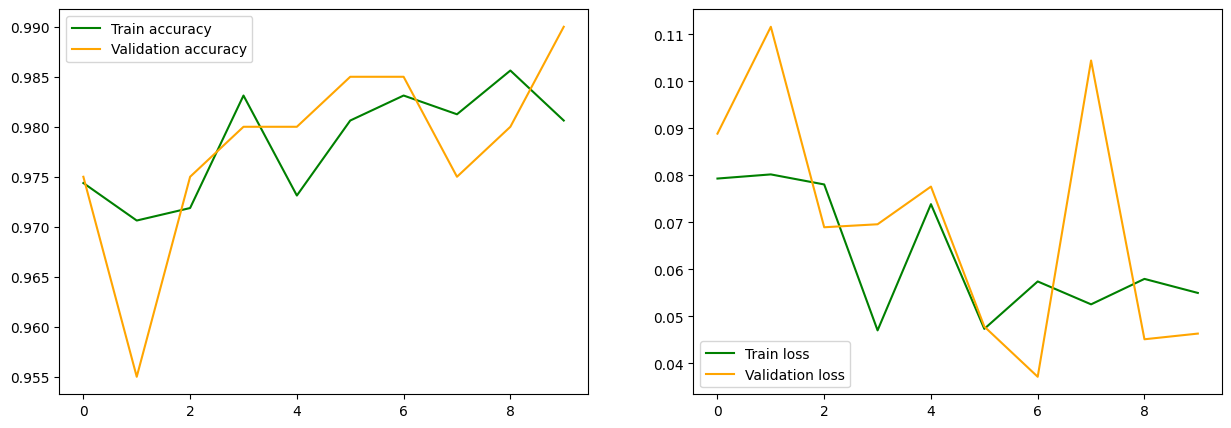

In [42]:

train_loop(10, 200, 0.007)

Epoch : 1, train accuracy : 0.9799999594688416, train loss : 0.06728529185056686
Epoch : 1, val_accuracy : 0.9749999642372131, val_loss : 0.08950236439704895
Epoch : 2, train accuracy : 0.9799999594688416, train loss : 0.06851537525653839
Epoch : 2, val_accuracy : 0.9699999690055847, val_loss : 0.09827163815498352
Epoch : 3, train accuracy : 0.9800000190734863, train loss : 0.05297364294528961
Epoch : 3, val_accuracy : 0.9899999499320984, val_loss : 0.04936860129237175
Epoch : 4, train accuracy : 0.9812499284744263, train loss : 0.0565478540956974
Epoch : 4, val_accuracy : 0.9899999499320984, val_loss : 0.049521706998348236
Epoch : 5, train accuracy : 0.9831249713897705, train loss : 0.05134459584951401
Epoch : 5, val_accuracy : 0.9699999690055847, val_loss : 0.0766349509358406
Epoch : 6, train accuracy : 0.9831249713897705, train loss : 0.04973315820097923
Epoch : 6, val_accuracy : 0.9749999642372131, val_loss : 0.07064306735992432
Epoch : 7, train accuracy : 0.9862499833106995, train

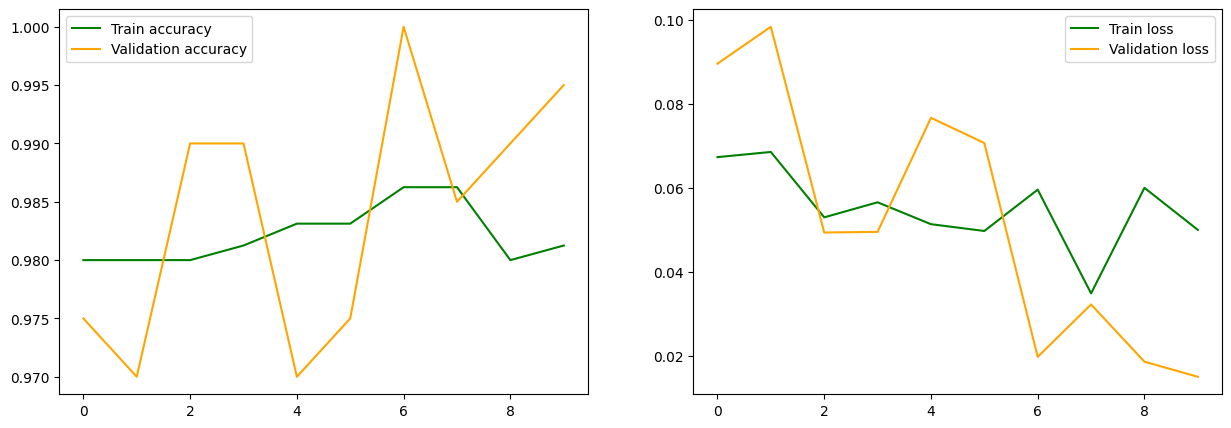

In [43]:

train_loop(10, 400, 0.007)

In [44]:
polar_bear_probs = []
model.eval()
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=100, shuffle=False
)
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = functional.softmax(preds, dim=1)[:, 1].tolist()
        polar_bear_probs += list(zip(list(fileid), preds_list))
polar_bear_probs.sort(key=lambda x: int(x[0]))
polar_bear_probs[17:24]

[(tensor(0), 0.0005609088111668825),
 (tensor(0), 0.009946894831955433),
 (tensor(0), 0.0028892126865684986),
 (tensor(0), 0.008667911402881145),
 (tensor(0), 0.0005136231775395572),
 (tensor(0), 0.00031758990371599793),
 (tensor(0), 2.289370786456857e-05)]

In [45]:
idx = list(i for i in range(len(polar_bear_probs)))
prob = list(map(lambda x: x[1],polar_bear_probs))
submission = pd.DataFrame({'id':idx,'label':prob})
submission.to_csv('result.csv',index=False)
submission

,id,label
0,0,0.002665
1,1,0.002382
2,2,0.000219
3,3,0.006343
4,4,0.000411
...,...,...
195,195,0.999877
196,196,0.999953
197,197,0.999999
198,198,0.998047


In [46]:
name_model = "model.pt"
torch.save(model.state_dict(), os.path.join("C:/Users/zhura/Desktop", name_model))

In [47]:
re_model = Cnn()
re_model.load_state_dict(torch.load(os.path.join("C:/Users/zhura/Desktop", name_model)))

<All keys matched successfully>

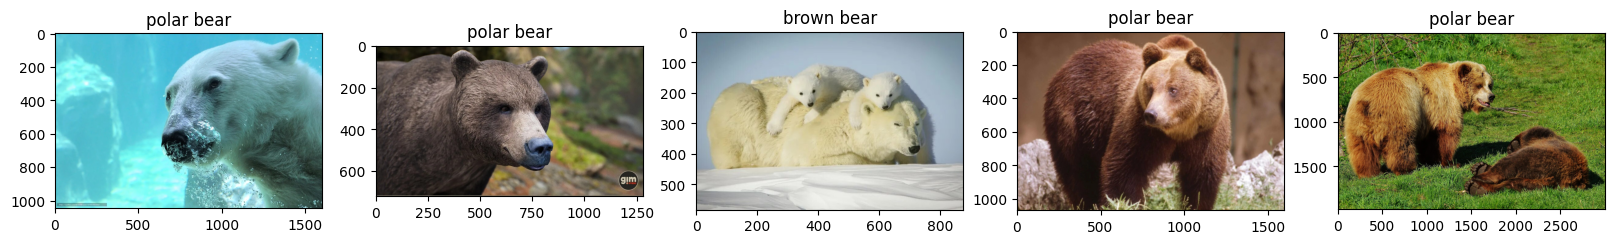

In [48]:
id_list = []

class_ = {0: 'polar bear', 1: 'brown bear'}

fig, axes = plt.subplots(1, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = train_list[i]
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)